In [ ]:
import numpy
import math
import matplotlib.pyplot as pyplot
import pandas
import seaborn

LAPTOP_PRICE_DATASET_FILE = 'Laptop_price.csv'
MIN_CORR_VALUE = 0.5

# Reading dataset and show correlation matrix


   Processor_Speed  RAM_Size  Storage_Capacity  Screen_Size    Weight  \
0         3.830296        16               512    11.185147  2.641094   
1         2.912833         4              1000    11.311372  3.260012   
2         3.241627         4               256    11.853023  2.029061   
3         3.806248        16               512    12.280360  4.573865   
4         3.268097        32              1000    14.990877  4.193472   

          Price  Brand_Asus  Brand_Dell  Brand_HP  Brand_Lenovo  
0  17395.093065           1           0         0             0  
1  31607.605919           0           0         0             0  
2   9291.023542           0           0         0             1  
3  17436.728334           0           0         0             0  
4  32917.990718           0           0         0             0  
Processor_Speed     0
RAM_Size            0
Storage_Capacity    0
Screen_Size         0
Weight              0
Price               0
Brand_Asus          0
Brand_Dell 

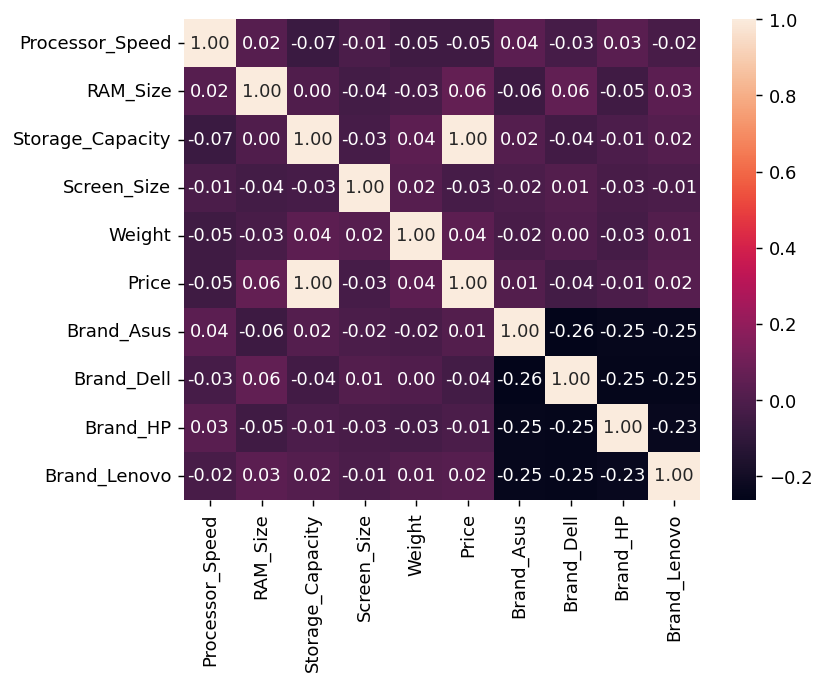

In [ ]:
dataset = pandas.read_csv(LAPTOP_PRICE_DATASET_FILE)
dataset = pandas.get_dummies(dataset, columns = ['Brand'], prefix = 'Brand', drop_first = True)

print(dataset.head())
print(dataset.isna().sum())

pyplot.figure(dpi = 130)
seaborn.heatmap(dataset.corr(), annot = True, fmt = '.2f')
pyplot.show()

# Analyze correlation matrix
We will get how our target correlates with other features

In [ ]:
target_corr_values = dataset.corr()['Price'].abs()
interested_futures = target_corr_values[target_corr_values >= MIN_CORR_VALUE].index.tolist()
interested_futures.remove('Price')
print(interested_futures)

['Storage_Capacity']


# Price distribution histogram

(array([355.,   2.,   0., 296.,  11.,   0.,   0.,   0.,   4., 332.]),
 array([ 8570.01295047, 11063.40515915, 13556.79736784, 16050.18957652,
        18543.58178521, 21036.97399389, 23530.36620258, 26023.75841126,
        28517.15061995, 31010.54282863, 33503.93503731]),
 <BarContainer object of 10 artists>)

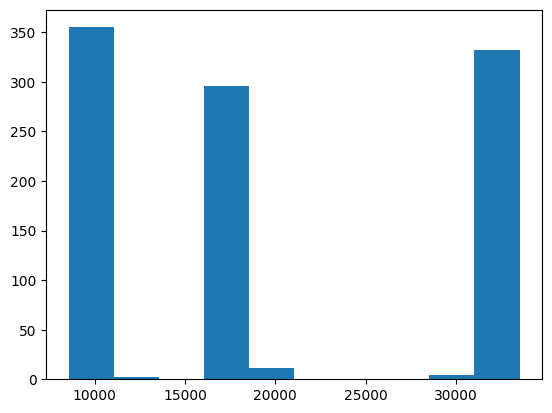

In [ ]:
pyplot.hist(dataset['Price'])

# Sturger rule for build intervals

In [ ]:
def sturger_rule(count: int) -> int:
    assert(count > 0)
    return 1 + math.floor(math.log2(count))

def get_stored_interval(sampled_intervals: list[float], value: float) -> int:
    for i in range(1, len(sampled_intervals)):
        if (value <= sampled_intervals[i]):
            return i

def discretization(left: float, right: float, rows_count: int) -> list[float]:
    intervals_count = sturger_rule(rows_count)
    assert(intervals_count > 0)

    step = (right - left) / intervals_count

    result = [left]
    current_val = left

    for _ in range(intervals_count):
        current_val += step
        result.append(current_val)

    result[intervals_count] = right

    return result


# Alternative build rule

In [ ]:
def get_stored_interval(value: float) -> str:
  if (value <= 15000):
    return "1"
  elif (value <= 25000):
    return "2"
  else:
    return "3"


# Entropy calc function

In [ ]:
def entropy(probabilities: list[float]) -> float:
    result = 0.0
    for value in probabilities:
        if (value > 0):
            result += value * math.log2(value)

    return -result

# I'm use alternative rule for target 'Price'

(array([307.,   0.,   0.,   0.,   0., 336.,   0.,   0.,   0., 357.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

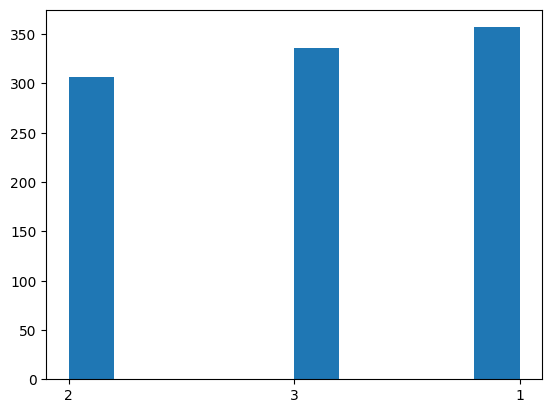

In [ ]:
dataset['Price_category'] = dataset['Price'].apply(get_stored_interval)
pyplot.hist(dataset['Price_category'])

# Calculate entropy for target 'Price'

In [ ]:
probabilities = [0 for _ in range(3)]

for value in dataset['Price_category']:
  probabilities[int(value) - 1] += 1

probabilities[0] /= len(dataset['Price_category'])
probabilities[1] /= len(dataset['Price_category'])
probabilities[2] /= len(dataset['Price_category'])

price_entropy = entropy(probabilities)

# Calculate gain ratio

In [ ]:
def gain_ratio():
  result = []

  for col in dataset.columns:
    if (col == 'Price' or col == 'Price_category'):
      continue

    gain_ratio = 0.0
    info_gain = 0.0
    split_info = 0.0
    condition_entropy = 0.0

    column_unique_values, count = numpy.unique(dataset[col], return_counts = True)
    frequency_matrix = [[0 for i in range(3)] for i in range(len(column_unique_values))]

    frequency_matrix_row = 0
    frequency_matrix_col = 0

    for idx, row in dataset.iterrows():
      frequency_matrix_col = int(row['Price_category']) - 1

      for i in range(len(column_unique_values)):
        if (column_unique_values[i] == row[col]):
          frequency_matrix_row = i
          break

      frequency_matrix[frequency_matrix_row][frequency_matrix_col] += 1

    total_values = len(dataset[col])

    for i in range(len(column_unique_values)):
      total_row_values = sum(frequency_matrix[i])
      acc = 0.0
      for j in range(3):
        fraq = frequency_matrix[i][j] / total_row_values
        if (fraq <= 0):
          continue
        acc -= fraq * math.log2(fraq)

      acc *= (total_row_values / total_values)
      condition_entropy += acc

    info_gain = price_entropy - condition_entropy

    for i in range(len(count)):
      fraq = count[i] / total_values
      split_info -= fraq * math.log2(fraq)

    result.append({col, info_gain / split_info})
    print(col, info_gain / split_info)

  return result

result = gain_ratio()


Processor_Speed 0.15876532279115552
RAM_Size 0.002286277990140446
Storage_Capacity 1.0
Screen_Size 0.15876532279115552
Weight 0.15876532279115552
Brand_Asus 0.002523469304389279
Brand_Dell 0.0019634225941905477
Brand_HP 0.002876237938911708
Brand_Lenovo 0.002902092605874561


# Testing

# Habr sample

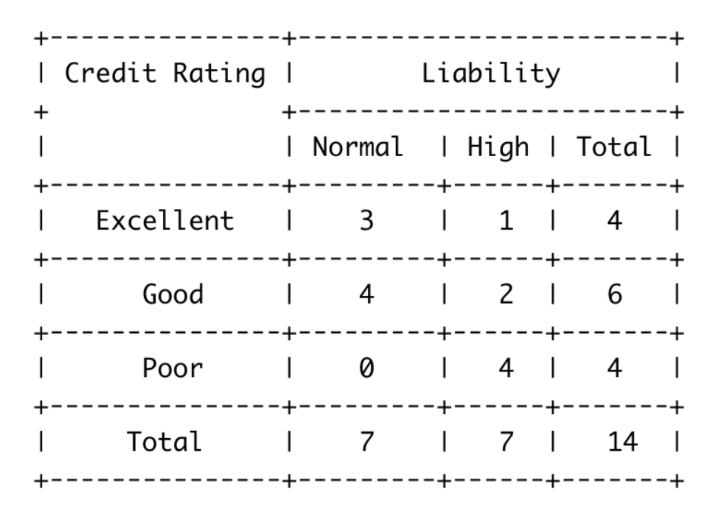

In [ ]:
import scipy.stats as stats
import unittest

MAX_ERROR = 1e-3

def sgn(x) -> int:
    return int(x / abs(x)) if x != 0 else 1

class Tests(unittest.TestCase):
  def setUp(self):
    pass

  def test_entropy(self):
    probabilities_1 = [1/4, 1/2, 1/4]
    probabilities_2 = [1/4, 1/4, 1/4, 1/4]
    probabilities_3 = [2/3, 1/3]

    result = entropy(probabilities_1)
    ans = stats.entropy(probabilities_1, base = 2)
    self.assertTrue(abs(result - ans) <= MAX_ERROR and sgn(ans) == sgn(result))

    result = entropy(probabilities_2)
    ans = stats.entropy(probabilities_2, base = 2)
    self.assertTrue(abs(result - ans) <= MAX_ERROR and sgn(ans) == sgn(result))

    result = entropy(probabilities_3)
    ans = stats.entropy(probabilities_3, base = 2)
    self.assertTrue(abs(result - ans) <= MAX_ERROR and sgn(ans) == sgn(result))

  def test_condition_entropy(self):
    # Habr dataset (https://habr.com/ru/companies/otus/articles/502200/)
    ans = 0.625

    frequency_matrix = [[3, 1], [4, 2], [0, 4]]
    condition_entropy = 0.0
    total_values = 14

    for i in range(3):
      total_row_values = sum(frequency_matrix[i])
      acc = 0.0
      for j in range(2):
        fraq = frequency_matrix[i][j] / total_row_values
        if (fraq <= 0):
          continue
        acc -= fraq * math.log2(fraq)

      acc *= (total_row_values / total_values)
      condition_entropy += acc

    self.assertTrue(abs(condition_entropy - ans) <= MAX_ERROR)


unittest.main(argv = ['first-arg-is-ignored'], exit = False)

..
----------------------------------------------------------------------
Ran 2 tests in 0.007s

OK
